In [1]:
!pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=a0a919f862142e8c5ebeb1a20d2c4a674604ffc3a49a48dd4b9d24168e37bd5b
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [2]:
# import函式庫
from sklearn import datasets, metrics, svm, tree, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization

In [3]:
# 讀入iris資料集
iris = datasets.load_iris()
# 定義feature及label
iris_data = iris.data
iris_label = iris.target

# 顯示iris的內容
print(pd.DataFrame(data=iris['data'], columns=iris['feature_names']))

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
1                  4.9               3.0                1.4               0.2
2                  4.7               3.2                1.3               0.2
3                  4.6               3.1                1.5               0.2
4                  5.0               3.6                1.4               0.2
..                 ...               ...                ...               ...
145                6.7               3.0                5.2               2.3
146                6.3               2.5                5.0               1.9
147                6.5               3.0                5.2               2.0
148                6.2               3.4                5.4               2.3
149                5.9               3.0                5.1               1.8

[150 rows x 4 columns]


In [4]:
# 將資料分成training及testing，比例為8:2，並亂序
train_data, test_data, train_label, test_label = train_test_split(iris_data, iris_label, test_size=0.2, shuffle=True)

In [5]:
# 前處理，將所有特徵標準化，能夠有效地讓模型快速收斂
# 使平均值為0，標準差為1
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [6]:
def svc_cv(C, gamma, data, targets):
  classifier = svm.SVC(C=C, kernel='rbf', gamma=gamma)
  cval = cross_val_score(classifier, data, targets, scoring='accuracy', cv=15)
  return cval.mean()

In [7]:
def svc_crossval(expC, expGamma):
  C = 10 ** expC
  gamma = 10 ** expGamma
  return svc_cv(C=C, gamma=gamma, data=train_data, targets=train_label)

In [8]:
optimizer = BayesianOptimization(f = svc_crossval,
                  pbounds = {"expC": (-3, 5), "expGamma": (0, 5)})
optimizer.maximize(n_iter=10)

print("Final result:", optimizer.max)
params = optimizer.max["params"]
C = params['expC']
gamma = params["expGamma"]

|   iter    |  target   |   expC    | expGamma  |
-------------------------------------------------
|  1        |  0.3333   |  2.432    |  4.464    |
|  2        |  0.9417   | -0.6817   |  0.001068 |
|  3        |  0.95     |  4.653    |  0.3336   |
|  4        |  0.3833   | -2.313    |  1.002    |
|  5        |  0.3083   | -0.4868   |  4.463    |
|  6        |  0.3      |  2.543    |  2.654    |
|  7        |  0.9333   |  4.163    |  0.05388  |
|  8        |  0.9333   |  1.056    |  0.0      |
|  9        |  0.3083   |  5.0      |  5.0      |
|  10       |  0.9167   |  0.1282   |  0.8468   |
|  11       |  0.9333   |  5.0      |  0.0      |
|  12       |  0.95     |  0.1542   |  0.0      |
|  13       |  0.9333   |  2.571    |  0.0      |
|  14       |  0.7      |  5.0      |  1.638    |
|  15       |  0.3083   | -3.0      |  5.0      |
Final result: {'target': 0.95, 'params': {'expC': 4.6532915993701645, 'expGamma': 0.33359675113055653}}


In [9]:
# 使用SVM演算法
classifier = svm.SVC(C=C, kernel='rbf', gamma=gamma)
classifier.fit(train_data, train_label)

SVC(C=4.6532915993701645, gamma=0.33359675113055653)

In [10]:
# 輸出預測結果及正確結果
predicted = classifier.predict(test_data)
print('predicted:', predicted)
print('true:     ', test_label)

predicted: [1 0 2 0 0 2 1 0 2 0 2 1 1 1 2 0 1 0 1 1 2 1 1 1 1 0 2 2 0 0]
true:      [1 0 2 0 0 2 1 0 2 0 2 1 2 1 2 0 1 0 1 1 2 1 1 1 1 0 2 2 0 0]


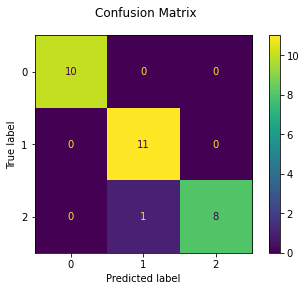

In [11]:
# 顯示混淆矩陣
disp = metrics.ConfusionMatrixDisplay.from_predictions(test_label, predicted)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

In [12]:
# 顯示結果報表
# precision = TP/(TP+FP)
# recall = TP/(TP+FN)
# f1-score= 2 * precision * recall/(recision + recall)，為precision和recall的harmonic mean調和平均數
# support為實際手寫數字的總數
print(f"Classification report for classifier {classifier}:\n"
   f"{metrics.classification_report(test_label, predicted)}\n"  )

Classification report for classifier SVC(C=4.6532915993701645, gamma=0.33359675113055653):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.92      1.00      0.96        11
           2       1.00      0.89      0.94         9

    accuracy                           0.97        30
   macro avg       0.97      0.96      0.97        30
weighted avg       0.97      0.97      0.97        30


